## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from os import walk
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    
    # load images
    for dirpath, dirnames, filenames in walk('data/images/'):
        break
    filenames.sort()
    imgs = []
    for img_name in filenames:
        img = imread(join('data/images', img_name))
        imgs.append(img)
    
    # load points
    points = pd.read_csv('data/gt.csv', index_col=0).values
    points = points.astype(float)
    
    # scale points
    for i in range(points.shape[0]):  # for each image&point
        size = imgs[i].shape  # the original size
        imgs[i] = resize(imgs[i], output_shape=(100,100,3))  # resize img
        for j in range(0, int(points.shape[1]), 2):
            points[i][j] = points[i][j]/size[1] - 0.5  # x - columns
            points[i][j+1] = points[i][j+1]/size[0] - 0.5  # y - rows
        
    return np.array(imgs), points

imgs, points = load_imgs_and_keypoints()

/home/william/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/william/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

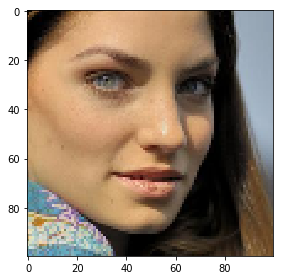

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

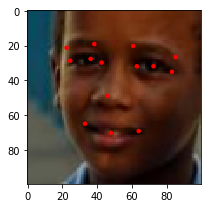

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    f, axe = plt.subplots(figsize=(3,3))
    imshow(img)
    for i in range(0, points.shape[0], 2):
        axe.add_artist(Circle((points[i]*100+50, points[i+1]*100+50), radius=1, color='r'))
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

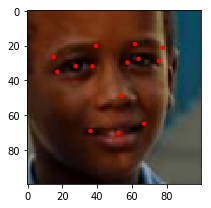

In [6]:
def flip_img(img, points):
    
    # flip img
    f_img = np.flip(img, axis=1)
    
    # flip points
    f_point = points.copy()
    for i in range(0, points.shape[0], 2):
        f_point[i] = -points[i]
    return f_img, f_point

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [7]:
aug_imgs_train = []
aug_points_train = []
for i in range(imgs_train.shape[0]):
    aug_img, aug_point = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_imgs_train.append(aug_img)
    aug_points_train.append(points_train[i])
    aug_points_train.append(aug_point)
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)

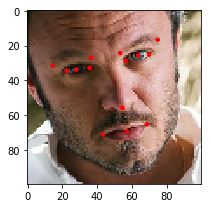

In [8]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

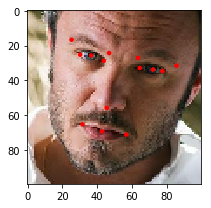

In [9]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [95]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)

model = Sequential()

model.add(BatchNormalization(input_shape=(100, 100, 3)))

model.add(Conv2D(filters=24, kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=36, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=48, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(units=500, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=90, activation='relu'))
model.add(Dropout(rate=0.25))

# output layer
model.add(Dense(units=28))

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [96]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, rmsprop

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)
model.fit(aug_imgs_train, aug_points_train, batch_size=20, epochs=30, verbose=1, callbacks=[checkpointer], validation_split=0.2, shuffle=True)

Train on 8640 samples, validate on 2160 samples
Epoch 1/30
8640/8640 [==============================] - 65s 8ms/step - loss: 0.0232 - acc: 0.0222 - val_loss: 0.0184 - val_acc: 0.0139

Epoch 00001: val_loss improved from inf to 0.01842, saving model to face_model.h5
Epoch 2/30
8640/8640 [==============================] - 63s 7ms/step - loss: 0.0183 - acc: 0.0212 - val_loss: 0.0180 - val_acc: 0.0315

Epoch 00002: val_loss improved from 0.01842 to 0.01804, saving model to face_model.h5
Epoch 3/30
8640/8640 [==============================] - 63s 7ms/step - loss: 0.0178 - acc: 0.0311 - val_loss: 0.0169 - val_acc: 0.0208

Epoch 00003: val_loss improved from 0.01804 to 0.01688, saving model to face_model.h5
Epoch 4/30
8640/8640 [==============================] - 63s 7ms/step - loss: 0.0175 - acc: 0.0446 - val_loss: 0.0170 - val_acc: 0.0153

Epoch 00004: val_loss did not improve from 0.01688
Epoch 5/30
8640/8640 [==============================] - 63s 7ms/step - loss: 0.0171 - acc: 0.0556 - val

In [100]:
points_pred = model.predict(x=imgs_val, batch_size=20, verbose=1)

600/600 [==============================] - 1s 2ms/step


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

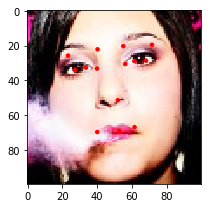

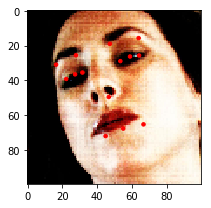

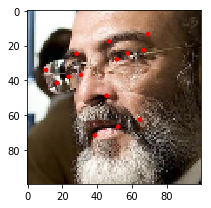

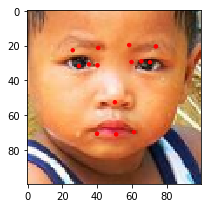

In [109]:
# Example of output
visualize_points(imgs_val[5], points_pred[5])
visualize_points(imgs_val[4], points_pred[4])
visualize_points(imgs_val[200], points_pred[200])
visualize_points(imgs_val[20], points_pred[20])